# Лабораторная 5. Трансформеры

**Выполнила Быковченко Софья, группа P4155**

In [1]:
import numpy as np
import pandas as pd
import re
import random
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

In [2]:
np.random.seed(42)
random.seed(42)

## Вспомогательные функции

Выполним базовую очистку входного текста:
- приведение к нижнему регистру
- удаление url-адресов
- удаление пунктуации и цифр
- нормализация пробелов

Это необходимо для формирования чистого корпуса слов, на основе которого строится словарь токенов. В трансформере входные данные рассматриваются не как последовательность во времени (как в RNN), а как набор элементов («множество»), где важны взаимосвязи между словами, а не их абсолютный порядок. Тем не менее порядок кодируется через позиционное кодирование, а не через RNN-состояния.

In [3]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return ' '.join(text.split())

Реализуем активацию Gaussian Error Linear Unit, которая используется в оригинальной архитектуре трансформера. В отличие от ReLU, GELU - гладкая нелинейность, что способствует более стабильному градиентному потоку. 

Трансформер - это стек нейросетевых блоков, каждый из которых содержит нелинейные преобразования. GELU позволяет модели лучше аппроксимировать сложные семантические зависимости между словами.

In [4]:
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

Соответственно, функция `gelu_grad` реализует аналитический градиент активации, необходимый для обратного распространения ошибки

In [5]:
def gelu_grad(x, grad_output):
    sqrt_2_over_pi = np.sqrt(2 / np.pi)
    cdf = 0.5 * (1 + np.tanh(sqrt_2_over_pi * (x + 0.044715 * x**3)))
    pdf = np.exp(-0.5 * x**2) * sqrt_2_over_pi
    return grad_output * (cdf + x * pdf)

`softmax` применяется в механизме внимания для нормализации весов, чтобы они образовывали распределение вероятностей. 

Механизм внимания вычисляет сходство между запросом (query) и ключами (keys), и именно через softmax это сходство превращается в веса, которыми взвешиваются значения (values)
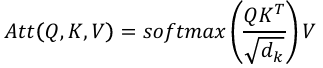


In [6]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

Реализуем нормализацию по признакам внутри каждого объекта (а не по батчу, как в BatchNorm). 

В трансформере нормализация используется после каждого подслоя (внимания и FFN) для стабилизации обучения и ускорения сходимости. Он обрабатывает все токены параллельно, поэтому внутри каждого токена необходимо нормализовать его представление.

Реализация включает прямой проход (вычисление нормированного вектора) и обратный проход (аналитические градиенты по входу и параметрам gamma, beta)

In [7]:
def layer_norm_forward(x, gamma, beta, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    return out, x_norm, mean, var

In [8]:
def layer_norm_backward(grad_out, x, x_norm, mean, var, gamma, eps=1e-6):
    N = x.shape[-1]
    d_norm = grad_out * gamma
    d_var = np.sum(d_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=-1, keepdims=True)
    d_mean = np.sum(d_norm * -1.0 / np.sqrt(var + eps), axis=-1, keepdims=True)
    d_mean += d_var * np.mean(-2.0 * (x - mean), axis=-1, keepdims=True)
    dx = d_norm / np.sqrt(var + eps) + d_var * 2.0 * (x - mean) / N + d_mean / N
    dgamma = np.sum(grad_out * x_norm, axis=(0, 1))
    dbeta = np.sum(grad_out, axis=(0, 1))
    return dx, dgamma, dbeta

Кросс-энтопию будем вычислять с сглаживанием меток. Вместо жестких [0, 1] используем смягченные [0.05, 0.95].

In [9]:
def cross_entropy_loss(y_true, y_pred):
    y_smooth = y_true * 0.9 + 0.05
    return -np.sum(y_smooth * np.log(np.clip(y_pred, 1e-8, 1.0))) / y_true.shape[0]

## Токенизатор

Для преобразования текста в числовой формат, пригодный для обработки нейросетью, реализуем простой токенизатор

In [10]:
class MyTokenizer:
    def __init__(self, max_words=10000):
        self.max_words = max_words
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
    
    def fit(self, texts):
        word_freq = {}
        for text in texts:
            for word in text.split():
                word_freq[word] = word_freq.get(word, 0) + 1
        sorted_words = sorted(word_freq.items(), key=lambda x: -x[1])
        for word, _ in sorted_words[:self.max_words - 2]:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
    
    def texts_to_sequences(self, texts, maxlen=64):
        seqs = []
        for text in texts:
            seq = [self.word2idx.get(w, 1) for w in text.split()]
            if len(seq) > maxlen:
                seq = seq[:maxlen]
            else:
                seq += [0] * (maxlen - len(seq))
            seqs.append(seq)
        return np.array(seqs, dtype=np.int32)

Класс выполняет две ключевые функции:
- fit - строит словарь из max_words наиболее частых слов обучающей выборки. Редкие слова в дальнейшем будут заменяться на токен <UNK> (unknown), а отсутствующие позиции — на <PAD> (padding).
- texts_to_sequences - преобразует текст в последовательность целочисленных индексов фиксированной длины (maxlen), применяя паддинг или обрезку.

## Оптимизатор Adam

Для эффективного обновления весов реализуем оптимизатор Adam.
Он адаптивно регулирует шаг обучения на основе первых и вторых моментов градиентов.

In [11]:
class MyAdam:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self, params, grads):
        self.t += 1
        for name in params:
            g = grads[name]
            p = params[name]

            if p.shape != g.shape:
                raise ValueError(f"Shape mismatch for '{name}': param {p.shape} and grad {g.shape}")

            if name not in self.m:
                self.m[name] = np.zeros_like(p)
                self.v[name] = np.zeros_like(p)
            else:
                if self.m[name].shape != p.shape:
                    self.m[name] = np.zeros_like(p)
                    self.v[name] = np.zeros_like(p)

            self.m[name] = self.beta1 * self.m[name] + (1 - self.beta1) * g
            self.v[name] = self.beta2 * self.v[name] + (1 - self.beta2) * (g ** 2)
            m_hat = self.m[name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[name] / (1 - self.beta2 ** self.t)
            params[name] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

##  Архитектура трансформера

Реализуем архитектура трансформеру, включающую все ключевые компоненты: эмбеддинги, позиционное кодирование, multi-head attention, LayerNorm, FFN и классификационную голову.

In [12]:
class MyTransformer:
    def __init__(self, vocab_size, embed_dim, d_model, n_heads, d_ff, n_layers, max_seq_len, num_classes, dropout=0.1):
        self.vocab_size = vocab_size      # размер словаря
        self.embed_dim = embed_dim        # размерность исходных эмбеддингов
        self.d_model = d_model            # внутренняя размерность (вектора Q, K, V)
        self.n_heads = n_heads            # количество голов внимания (Multi-Head)
        self.d_k = d_model // n_heads     # размерность на одну голову (dk)
        self.d_ff = d_ff                  # размерность скрытого слоя FFN
        self.n_layers = n_layers          # количество энкодерных блоков
        self.max_seq_len = max_seq_len    # максимальная длина входной последовательности
        self.num_classes = num_classes    # число классов (2: токсичный/нетоксичный)
        self.dropout = dropout            # регуляризация

        # 1) эмбеддинги слов
        # делаются эмбеддинги для всех слов предложения
        self.W_emb = np.random.normal(0, 0.02, (vocab_size, embed_dim))

        # проекция embed_dim -> d_model (если они не совпадают)
        self.W_proj1 = np.random.normal(0, 0.02, (embed_dim, d_model))
        self.b_proj1 = np.zeros(d_model)
        self.W_proj2 = np.random.normal(0, 0.02, (d_model, d_model))
        self.b_proj2 = np.zeros(d_model)

        # 2) позиционное кодирование
        # добавляется еще позиция слова
        pe = np.zeros((max_seq_len, d_model))
        pos = np.arange(max_seq_len)[:, None]
        div = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(pos * div) # чётные индексы - sin
        pe[:, 1::2] = np.cos(pos * div) # нечётные - cos
        self.pos_encoding = pe

        # 3) стек энкодерных слоёв
        # каждый слой: Multi-Head Attention -> LayerNorm -> FFN -> LayerNorm
        self.layers = []
        for _ in range(n_layers):
            layer = {
                # Multi-Head Attention
                'Wq': np.random.normal(0, 0.02, (d_model, d_model)), # лин. преобразование для Query
                'Wk': np.random.normal(0, 0.02, (d_model, d_model)), # для Key
                'Wv': np.random.normal(0, 0.02, (d_model, d_model)), # для Value
                'Wo': np.random.normal(0, 0.02, (d_model, d_model)), # финальная проекция после конкатенации голов
                'bq': np.zeros(d_model),
                'bk': np.zeros(d_model),
                'bv': np.zeros(d_model),
                'bo': np.zeros(d_model),

                # Layer Normalization
                'gamma1': np.ones(d_model), # масштаб после MHA
                'beta1': np.zeros(d_model), # сдвиг после MHA

                 #Feed-Forward Network (FFN)
                'W1': np.random.normal(0, 0.02, (d_model, d_ff)), # скрытый слой
                'b1': np.zeros(d_ff),
                'W2': np.random.normal(0, 0.02, (d_ff, d_model)), # проекция обратно в d_model
                'b2': np.zeros(d_model),
                
                'gamma2': np.ones(d_model), # масштаб после FFN
                'beta2': np.zeros(d_model) # сдвиг после FFN
            }
            self.layers.append(layer)

        # 4) классификационная голова
        # глобальное усреднение с маской -> MLP -> softmax    
        self.Wc1 = np.random.normal(0, 0.02, (d_model, 256))
        self.bc1 = np.zeros(256)
        self.Wc2 = np.random.normal(0, 0.02, (256, 128))
        self.bc2 = np.zeros(128)
        self.Wc3 = np.random.normal(0, 0.02, (128, num_classes))
        self.bc3 = np.zeros(num_classes)

    def forward(self, input_ids, mask):
        """
        прямой проход трансформера
        
        input_ids: [batch_size, seq_len] - индексы слов
        mask: [batch_size, seq_len] - маска паддинга (1 - реальное слово, 0 - <PAD>)
        """
        cache = {}
        batch_size, seq_len = input_ids.shape

        # 1. эмбеддинги слов
        x = self.W_emb[input_ids]
        cache['emb'] = x

        # 2. проекция в пространство d_model
        x = np.matmul(x, self.W_proj1) + self.b_proj1
        x1_act = x.copy()
        x = gelu(x1_act)
        cache['proj1'] = (x1_act, x)

        x = np.matmul(x, self.W_proj2) + self.b_proj2
        cache['proj2'] = x

        # 3. добавление позиционного кодирования
        x = x + self.pos_encoding[:seq_len]
        if self.dropout > 0:
            keep_mask = (np.random.rand(*x.shape) > self.dropout) / (1 - self.dropout)
            x = x * keep_mask
        cache['pos'] = x

        # 4. проход через стек энкодерных слоёв
        for i, layer in enumerate(self.layers):
            key = f'layer_{i}'
            cache[key] = {}

            # Multi-Head Attention
            Q = np.matmul(x, layer['Wq']) + layer['bq']
            K = np.matmul(x, layer['Wk']) + layer['bk']
            V = np.matmul(x, layer['Wv']) + layer['bv']
            
            # разделение на головы [B, L, d_model] -> [B, H, L, dk]
            def split_heads(tensor):
                new_shape = tensor.shape[:-1] + (self.n_heads, self.d_k)
                tensor = tensor.reshape(new_shape)
                return np.transpose(tensor, (0, 2, 1, 3))

            Q_split = split_heads(Q)
            K_split = split_heads(K)
            V_split = split_heads(V)
            
            # вычисление весов внимания softmax(QK^T / sqrt(dk))
            scores = np.matmul(Q_split, np.transpose(K_split, (0, 1, 3, 2))) / np.sqrt(self.d_k)
            if mask is not None:
                mask_exp = mask[:, None, None, :] # [B, 1, 1, L]
                scores = np.where(mask_exp == 1, scores, -1e9)

            attn = softmax(scores) # [B, H, L, L]
            context = np.matmul(attn, V_split) # [B, H, L, dk]

            # объединение голов [B, H, L, dk] -> [B, L, d_model]
            context = np.transpose(context, (0, 2, 1, 3))
            context = context.reshape(batch_size, seq_len, self.d_model)

            attn_out = np.matmul(context, layer['Wo']) + layer['bo']
            cache[key]['mha'] = {
                'Q': Q, 'K': K, 'V': V,
                'Q_split': Q_split, 'K_split': K_split, 'V_split': V_split,
                'scores': scores, 'attn': attn,
                'context': context, 'attn_out': attn_out,
                'x_in': x
            }

            # остаточная связь + LayerNorm
            x1 = x + attn_out
            x_norm1, x_norm1_normed, mean1, var1 = layer_norm_forward(x1, layer['gamma1'], layer['beta1'])
            cache[key]['ln1'] = (x1, x_norm1_normed, mean1, var1)
            x = x_norm1
            
            # FFN
            x_ff1_pre = np.matmul(x, layer['W1']) + layer['b1']
            x_ff1 = gelu(x_ff1_pre)
            if self.dropout > 0:
                keep_mask = (np.random.rand(*x_ff1.shape) > self.dropout) / (1 - self.dropout)
                x_ff1 = x_ff1 * keep_mask
            x_ff2 = np.matmul(x_ff1, layer['W2']) + layer['b2']
            cache[key]['ffn'] = {'x_in': x, 'x_ff1_pre': x_ff1_pre, 'x_ff1': x_ff1, 'x_ff2': x_ff2}
            
            # остаточная связь + LayerNorm
            x2 = x + x_ff2
            x_norm2, x_norm2_normed, mean2, var2 = layer_norm_forward(x2, layer['gamma2'], layer['beta2'])
            cache[key]['ln2'] = (x2, x_norm2_normed, mean2, var2)
            x = x_norm2

        # 5. классификация: маскированное усреднение -> MLP
        mask_f = mask[..., None] # [B, L, 1]
        x_sum = np.sum(x * mask_f, axis=1) # сумма по словам
        x_len = np.sum(mask, axis=1, keepdims=True) # реальная длина
        x_pooled = x_sum / np.maximum(x_len, 1.0) # усреднение без паддинга
        cache['pool'] = (x, mask_f, x_pooled)
        
        # MLP голова
        x_c1_pre = np.matmul(x_pooled, self.Wc1) + self.bc1
        x_c1 = gelu(x_c1_pre)
        x_c2_pre = np.matmul(x_c1, self.Wc2) + self.bc2
        x_c2 = gelu(x_c2_pre)
        logits = np.matmul(x_c2, self.Wc3) + self.bc3
        probs = softmax(logits)

        cache['cls'] = {
            'x_pooled': x_pooled,
            'x_c1_pre': x_c1_pre, 'x_c1': x_c1,
            'x_c2_pre': x_c2_pre, 'x_c2': x_c2,
            'logits': logits, 'probs': probs
        }

        return probs, cache

    def backward(self, y_true, cache, input_ids, mask):
        """Обратный проход"""
        grads = {}
        cls = cache['cls']
        probs = cls['probs']
        x_c2 = cls['x_c2']
        x_c1 = cls['x_c1']
        x_pooled = cls['x_pooled']

        y_smooth = y_true * 0.9 + 0.05
        dlogits = (probs - y_smooth) / y_true.shape[0]

        grads['Wc3'] = np.matmul(x_c2.T, dlogits)
        grads['bc3'] = np.sum(dlogits, axis=0)

        dx_c2 = np.matmul(dlogits, self.Wc3.T)
        dx_c2 = gelu_grad(cls['x_c2_pre'], dx_c2)

        grads['Wc2'] = np.matmul(x_c1.T, dx_c2)
        grads['bc2'] = np.sum(dx_c2, axis=0)

        dx_c1 = np.matmul(dx_c2, self.Wc2.T)
        dx_c1 = gelu_grad(cls['x_c1_pre'], dx_c1)

        grads['Wc1'] = np.matmul(x_pooled.T, dx_c1)
        grads['bc1'] = np.sum(dx_c1, axis=0)

        d_pooled = np.matmul(dx_c1, self.Wc1.T)

        x, mask_f, _ = cache['pool']
        mask_sum = np.sum(mask, axis=1, keepdims=True)
        dx = np.zeros_like(x)

        for b in range(x.shape[0]):
            eff_len = max(mask_sum[b, 0], 1.0)
            dx[b] = (d_pooled[b] / eff_len) * mask[b][:, np.newaxis]

        for i in reversed(range(len(self.layers))):
            key = f'layer_{i}'
            layer = self.layers[i]
            ln2_cache = cache[key]['ln2']
            ffn_cache = cache[key]['ffn']
            ln1_cache = cache[key]['ln1']
            mha_cache = cache[key]['mha']

            x2, x_norm2, mean2, var2 = ln2_cache
            dx, dgamma2, dbeta2 = layer_norm_backward(dx, x2, x_norm2, mean2, var2, layer['gamma2'])
            grads[f'layer_{i}_gamma2'] = dgamma2
            grads[f'layer_{i}_beta2'] = dbeta2
            
            d_ff2 = dx
            d_ff1 = np.matmul(d_ff2, layer['W2'].T)
            d_ff1 = gelu_grad(ffn_cache['x_ff1_pre'], d_ff1)

            B, L, d_ff_val = ffn_cache['x_ff1'].shape
            d_model_val = d_ff2.shape[-1]

            x_ff1_flat = ffn_cache['x_ff1'].reshape(-1, d_ff_val)
            d_ff2_flat = d_ff2.reshape(-1, d_model_val)
            d_ff1_flat = d_ff1.reshape(-1, d_ff_val)
            x_in_flat = ffn_cache['x_in'].reshape(-1, d_model_val)

            grads[f'layer_{i}_W2'] = np.matmul(x_ff1_flat.T, d_ff2_flat)
            grads[f'layer_{i}_b2'] = np.sum(d_ff2_flat, axis=0)

            grads[f'layer_{i}_W1'] = np.matmul(x_in_flat.T, d_ff1_flat)
            grads[f'layer_{i}_b1'] = np.sum(d_ff1_flat, axis=0)

            dx = np.matmul(d_ff1, layer['W1'].T)
            dx += d_ff2

            x1, x_norm1, mean1, var1 = ln1_cache
            dx, dgamma1, dbeta1 = layer_norm_backward(dx, x1, x_norm1, mean1, var1, layer['gamma1'])
            grads[f'layer_{i}_gamma1'] = dgamma1
            grads[f'layer_{i}_beta1'] = dbeta1
            
            d_attn_out = dx
            d_context = np.matmul(d_attn_out, layer['Wo'].T)
            grads[f'layer_{i}_Wo'] = np.matmul(mha_cache['context'].reshape(-1, self.d_model).T,
                                               d_attn_out.reshape(-1, self.d_model))
            grads[f'layer_{i}_bo'] = np.sum(d_attn_out, axis=(0,1))

            batch_size, seq_len = dx.shape[0], dx.shape[1]
            d_context_split = d_context.reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(0, 2, 1, 3)

            dV_split = np.matmul(mha_cache['attn'].transpose(0, 1, 3, 2), d_context_split)
            dV = dV_split.transpose(0, 2, 1, 3).reshape(-1, self.d_model)
            V_flat = mha_cache['V'].reshape(-1, self.d_model)
            grads[f'layer_{i}_Wv'] = np.matmul(V_flat.T, dV)
            grads[f'layer_{i}_bv'] = np.sum(dV, axis=0)

            A = mha_cache['attn']
            dA = np.matmul(d_context_split, mha_cache['V_split'].transpose(0, 1, 3, 2))
            d_scores = A * (dA - np.sum(A * dA, axis=-1, keepdims=True)) / np.sqrt(self.d_k)

            dQ_split = np.matmul(d_scores, mha_cache['K_split'])
            dK_split = np.matmul(d_scores.transpose(0, 1, 3, 2), mha_cache['Q_split'])

            dQ = dQ_split.transpose(0, 2, 1, 3).reshape(-1, self.d_model)
            dK = dK_split.transpose(0, 2, 1, 3).reshape(-1, self.d_model)
            Q_flat = mha_cache['Q'].reshape(-1, self.d_model)
            K_flat = mha_cache['K'].reshape(-1, self.d_model)

            grads[f'layer_{i}_Wq'] = np.matmul(Q_flat.T, dQ)
            grads[f'layer_{i}_bq'] = np.sum(dQ, axis=0)
            grads[f'layer_{i}_Wk'] = np.matmul(K_flat.T, dK)
            grads[f'layer_{i}_bk'] = np.sum(dK, axis=0)

            dx = dQ.reshape(batch_size, seq_len, self.d_model) + \
                 dK.reshape(batch_size, seq_len, self.d_model) + \
                 dV.reshape(batch_size, seq_len, self.d_model) + d_attn_out

        d_proj2 = dx
        d_proj1_act = np.matmul(d_proj2, self.W_proj2.T)
        d_proj1 = gelu_grad(cache['proj1'][0], d_proj1_act)

        x_proj1_flat = cache['proj1'][1].reshape(-1, self.d_model)
        d_proj2_flat = d_proj2.reshape(-1, self.d_model)
        grads['W_proj2'] = np.matmul(x_proj1_flat.T, d_proj2_flat)
        grads['b_proj2'] = np.sum(d_proj2_flat, axis=0)

        d_emb = np.matmul(d_proj1, self.W_proj1.T)
        x_emb_flat = cache['emb'].reshape(-1, self.embed_dim)
        d_proj1_flat = d_proj1.reshape(-1, self.d_model)
        grads['W_proj1'] = np.matmul(x_emb_flat.T, d_proj1_flat)
        grads['b_proj1'] = np.sum(d_proj1_flat, axis=0)

        grad_emb = np.zeros_like(self.W_emb)
        for b in range(input_ids.shape[0]):
            for t in range(input_ids.shape[1]):
                word_id = input_ids[b, t]
                grad_emb[word_id] += d_emb[b, t]
        grads['W_emb'] = grad_emb

        return grads

    def predict(self, input_ids, mask, batch_size=32):
        n = len(input_ids)
        all_probs = []
        for i in range(0, n, batch_size):
            x_batch = input_ids[i:i+batch_size]
            m_batch = mask[i:i+batch_size]
            probs, _ = self.forward(x_batch, m_batch)
            all_probs.append(probs)
        return np.vstack(all_probs)

## Загрузка и предобработка данных

Датасет «Toxic Russian Comments from Pikabu and 2ch» содержит 9 652 русскоязычных комментария, собранных с популярных интернет-платформ Pikabu и 2ch, каждый из которых размечен бинарной меткой:

- 0 — нетоксичный (нейтральный или корректный)
- 1 — токсичный (оскорбительный, агрессивный, нарушающий нормы общения)

In [13]:
df = pd.read_csv('russian_comments_from_2ch_pikabu.csv')
df = df.dropna(subset=['comment'])

Первым шагом удаляем строки, в которых отсутствует текст комментария, чтобы исключить артефакты и пропуски. Затем каждый комментарий пройдет базовую текстовую предобработку: приведение к нижнему регистру, удаление ссылок, цифр и пунктуации. Это позволяет уменьшить влияние несущественной информации и унифицировать формат входных данных.

In [14]:
df['comment'] = df['comment'].apply(preprocess_text)

После очистки из датасета исключаем слишком короткие комментарии, так как они не содержат достаточного контекста для корректной классификации

In [15]:
df = df[df['comment'].str.len() > 5]

Исходные данные несбалансированы (токсичных комментариев меньше), выполним балансировку

Из класса нетоксичных комментариев случайным образом отбираем столько же примеров, сколько имеется токсичных. Полученный сбалансированный набор перемешиваем для равномерного распределения классов.

In [16]:
toxic = df[df['toxic'] == 1]
non_toxic = df[df['toxic'] == 0].sample(n=len(toxic), random_state=42)
df_balanced = pd.concat([toxic, non_toxic]).sample(frac=1, random_state=42).reset_index(drop=True)

Наконец, данные разделяются в соотношении 80/20:
- 80% - обучающая выборка
- 20% - валидационная выборка

In [17]:
train_size = int(0.8 * len(df_balanced))
train_df = df_balanced[:train_size]
val_df = df_balanced[train_size:]

In [18]:
X_train, y_train = train_df['comment'].tolist(), train_df['toxic'].values.astype(np.int32)
X_val, y_val = val_df['comment'].tolist(), val_df['toxic'].values.astype(np.int32)

## Подготовка текстовых данных с использованием токенизатора

Перед подачей текстов в нейросеть их необходимо преобразовать в числовой формат. Для этого используем токенизацию.

Задаём ограничения

Словарь будет содержать не более 10 000 наиболее частых слов, а длина любой последовательности - не более 64 токенов. Это позволит контролировать потребление памяти и ускорит обучение

In [19]:
max_seq_len = 64
tokenizer = MyTokenizer(max_words=10000)
tokenizer.fit(X_train)

Каждый комментарий преобразуется в последовательность целых чисел, где:
- каждое число - индекс слова в словаре
- редкие слова заменяются на специальный токен <UNK>
- короткие последовательности дополняются нулями (padding до 64)
- длинные - обрезаются (до 64).

In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train, max_seq_len)
X_val_seq = tokenizer.texts_to_sequences(X_val, max_seq_len)

Поскольку часть последовательностей содержит нулевые паддинг-токены, необходимо сообщить модели, какие позиции следует игнорировать. Для этого создаются бинарные маски:
- 1 - реальное слово
- 0 - паддинг

Эти маски используются в механизме внимания (чтобы не учитывать паддинг при вычислении весов),
при пулинге (усреднении по последовательности).

In [21]:
train_mask = (X_train_seq != 0).astype(np.float32)
val_mask = (X_val_seq != 0).astype(np.float32)

Метки классов (0 и 1) преобразуются в формат one-hot encoding
- [1, 0] для нетоксичных
- [0, 1] для токсичных комментариев

In [22]:
y_train_onehot = np.eye(2)[y_train]
y_val_onehot = np.eye(2)[y_val]

## Обучение

In [23]:
vocab_size = len(tokenizer.word2idx)
model = MyTransformer(
    vocab_size=vocab_size,
    embed_dim=128,
    d_model=128,
    n_heads=4,
    d_ff=256,
    n_layers=2,
    max_seq_len=max_seq_len,
    num_classes=2,
    dropout=0.1
)
optimizer = MyAdam(lr=2e-4)

In [24]:
epochs = 20
batch_size = 32
patience = 4
lr_patience = 2
lr_factor = 0.5
min_lr = 1e-5

In [25]:
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
lr_loss_history = []

In [26]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'f1': [], 'val_f1': [], 'lr': []}

In [27]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} (lr={optimizer.lr:.2e})")
    indices = np.random.permutation(len(X_train_seq))
    X_train_shuffled = X_train_seq[indices]
    y_train_shuffled = y_train_onehot[indices]
    mask_train_shuffled = train_mask[indices]

    epoch_loss = 0.0
    num_batches = 0
    num_samples = len(X_train_shuffled)
    num_steps = math.ceil(num_samples / batch_size)
    
    pbar = tqdm(range(0, num_samples, batch_size), total=num_steps, desc="Training", unit="batch")
    for i in pbar:
        x_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        m_batch = mask_train_shuffled[i:i+batch_size]

        probs, cache = model.forward(x_batch, m_batch)
        loss = cross_entropy_loss(y_batch, probs)
        epoch_loss += loss
        num_batches += 1

        grads = model.backward(y_batch, cache, x_batch, m_batch)

        param_dict = {
            'W_emb': model.W_emb,
            'W_proj1': model.W_proj1, 'b_proj1': model.b_proj1,
            'W_proj2': model.W_proj2, 'b_proj2': model.b_proj2,
            'Wc1': model.Wc1, 'bc1': model.bc1,
            'Wc2': model.Wc2, 'bc2': model.bc2,
            'Wc3': model.Wc3, 'bc3': model.bc3
        }
        for j, layer in enumerate(model.layers):
            for k in layer:
                param_dict[f'layer_{j}_{k}'] = layer[k]

        optimizer.step(param_dict, grads)
        pbar.set_postfix({'batch_loss': f"{loss:.4f}", 'avg_loss': f"{epoch_loss/num_batches:.4f}"})

    avg_loss = epoch_loss / num_batches
    history['loss'].append(avg_loss)

    # валидация
    probs_val = model.predict(X_val_seq, val_mask, batch_size=batch_size)
    preds_val = np.argmax(probs_val, axis=1)
    acc = accuracy_score(y_val, preds_val)
    f1 = f1_score(y_val, preds_val)
    val_loss = cross_entropy_loss(y_val_onehot, probs_val)

    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(acc)
    history['val_f1'].append(f1)
    history['lr'].append(optimizer.lr)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss:{avg_loss:.4f}")
    print(f"  Val Loss:{val_loss:.4f}")
    print(f"  Val Accuracy:{acc:.4f}")
    print(f"  Val F1-Score:{f1:.4f}")

    # ранняя остановка и адаптивный LR
    lr_loss_history.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        print("!!!!!Новый лучший результат!!!!!")
    else:
        patience_counter += 1

        if patience_counter >= lr_patience and len(lr_loss_history) >= lr_patience + 1:
            recent = lr_loss_history[-(lr_patience+1):]
            if all(recent[i] <= recent[i+1] + 1e-4 for i in range(len(recent)-1)):
                if optimizer.lr > min_lr:
                    optimizer.lr = max(optimizer.lr * lr_factor, min_lr)
                    print(f"!!!!!Снижение learning rate до {optimizer.lr:.2e}!!!!!")
                    lr_loss_history = []

        if patience_counter >= patience:
            print(f"\n!!!!! Ранняя остановка на эпохе {epoch+1} (лучший результат на эпохе {best_epoch+1}) !!!!!")
            break

print("\nОбучение завершено.")


Epoch 1/20 (lr=2.00e-04)


Training: 100%|██████████| 242/242 [01:56<00:00,  2.08batch/s, batch_loss=0.4853, avg_loss=0.6409]



Epoch 1 Summary:
  Train Loss:0.6409
  Val Loss:0.5576
  Val Accuracy:0.7473
  Val F1-Score:0.7464
!!!!!Новый лучший результат!!!!!

Epoch 2/20 (lr=2.00e-04)


Training: 100%|██████████| 242/242 [01:56<00:00,  2.08batch/s, batch_loss=0.3528, avg_loss=0.4295]



Epoch 2 Summary:
  Train Loss:0.4295
  Val Loss:0.4545
  Val Accuracy:0.8317
  Val F1-Score:0.8460
!!!!!Новый лучший результат!!!!!

Epoch 3/20 (lr=2.00e-04)


Training: 100%|██████████| 242/242 [01:56<00:00,  2.08batch/s, batch_loss=0.4544, avg_loss=0.3201]



Epoch 3 Summary:
  Train Loss:0.3201
  Val Loss:0.4589
  Val Accuracy:0.8452
  Val F1-Score:0.8516

Epoch 4/20 (lr=2.00e-04)


Training: 100%|██████████| 242/242 [01:56<00:00,  2.08batch/s, batch_loss=0.2377, avg_loss=0.2803]



Epoch 4 Summary:
  Train Loss:0.2803
  Val Loss:0.4966
  Val Accuracy:0.8389
  Val F1-Score:0.8481
!!!!!Снижение learning rate до 1.00e-04!!!!!

Epoch 5/20 (lr=1.00e-04)


Training: 100%|██████████| 242/242 [01:56<00:00,  2.08batch/s, batch_loss=0.2003, avg_loss=0.2579]



Epoch 5 Summary:
  Train Loss:0.2579
  Val Loss:0.4912
  Val Accuracy:0.8446
  Val F1-Score:0.8504

Epoch 6/20 (lr=1.00e-04)


Training: 100%|██████████| 242/242 [02:09<00:00,  1.87batch/s, batch_loss=0.2032, avg_loss=0.2513]



Epoch 6 Summary:
  Train Loss:0.2513
  Val Loss:0.5011
  Val Accuracy:0.8457
  Val F1-Score:0.8467

!!!!! Ранняя остановка на эпохе 6 (лучший результат на эпохе 2) !!!!!

Обучение завершено.


## Оценка качества

In [28]:
y_pred = model.predict(X_val_seq, val_mask, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_val

In [29]:
print("Финальные результаты оценки:")
print(f"Accuracy:  {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"F1 Score:  {f1_score(y_true_classes, y_pred_classes):.4f}")

Финальные результаты оценки:
Accuracy:  0.8441
F1 Score:  0.8454


In [30]:
print(classification_report(y_true_classes, y_pred_classes, target_names=['Нетоксичный', 'Токсичный']))

              precision    recall  f1-score   support

 Нетоксичный       0.85      0.84      0.84       960
   Токсичный       0.84      0.85      0.85       971

    accuracy                           0.84      1931
   macro avg       0.84      0.84      0.84      1931
weighted avg       0.84      0.84      0.84      1931



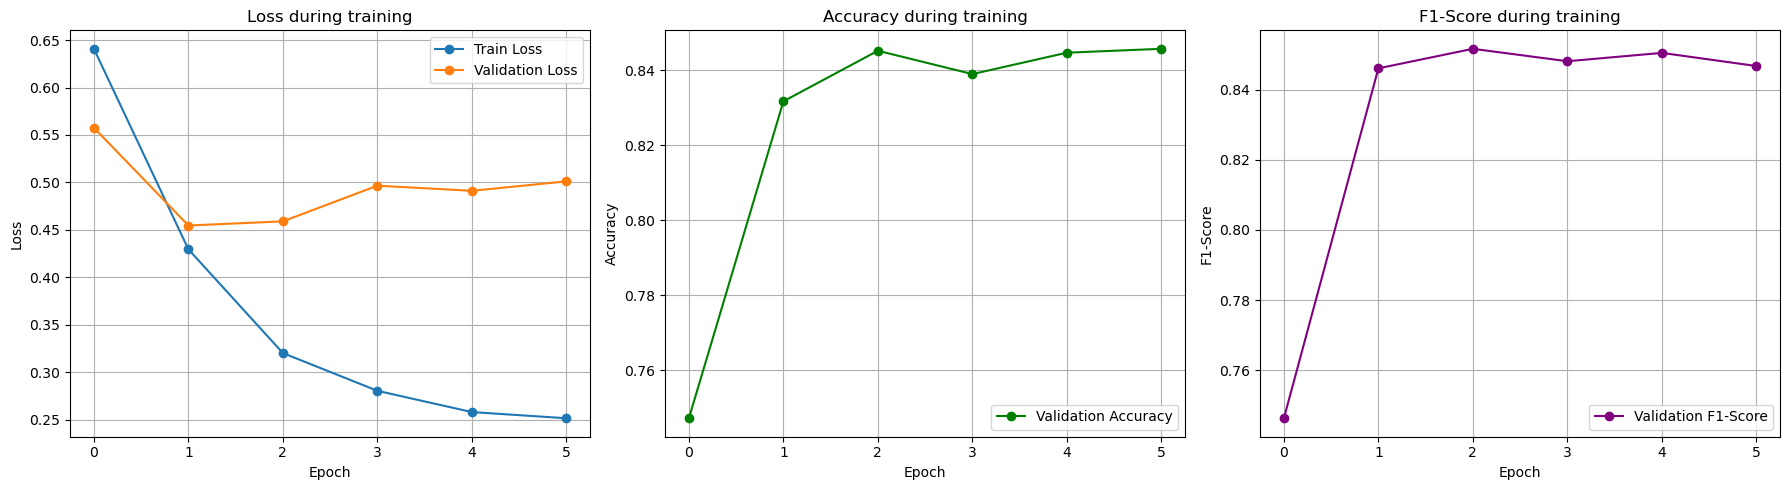

In [31]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1-Score', marker='o', color='purple')
plt.title('F1-Score during training')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
def predict_toxicity(comment, model, tokenizer, max_seq_len):
    processed_comment = preprocess_text(comment)
    seq = tokenizer.texts_to_sequences([processed_comment])[0].tolist()
    if len(seq) == 0:
        seq = [1]
    if len(seq) > max_seq_len:
        seq = seq[:max_seq_len]
    else:
        seq = seq + [0] * (max_seq_len - len(seq))
    padded = np.array([seq], dtype=np.int32)
    mask = (padded != 0).astype(np.float32)
    probs = model.predict(padded, mask, batch_size=1)
    toxic_prob = probs[0][1]
    class_pred = 1 if toxic_prob > 0.5 else 0
    return class_pred, toxic_prob

In [33]:
test_comments = [
    "Этот комментарий совершенно нормальный и корректный.",
    "Ты дурак и ничего не понимаешь в этой теме!",
    "Какой ужасный пост, автор - идиот!",
    "Спасибо за полезную информацию, очень помогло!",
    "Это самая глупая мысль, которую я когда-либо слышал",
    "Все отлично, спасибо за статью!",
    "Ты полный идиот, ничего не смыслишь в этой теме",
    "Мне не нравится ваш подход к решению этой проблемы"
]

In [34]:
for comment in test_comments:
    class_pred, toxic_prob = predict_toxicity(comment, model, tokenizer, max_seq_len)
    label = 'токсичный' if class_pred == 1 else 'нетоксичный'
    print(f"Комментарий: '{comment}'")
    print(f"Предсказание: {label}, Вероятность токсичности: {toxic_prob:.4f}")
    print("-" * 80)

Комментарий: 'Этот комментарий совершенно нормальный и корректный.'
Предсказание: нетоксичный, Вероятность токсичности: 0.1758
--------------------------------------------------------------------------------
Комментарий: 'Ты дурак и ничего не понимаешь в этой теме!'
Предсказание: токсичный, Вероятность токсичности: 0.9277
--------------------------------------------------------------------------------
Комментарий: 'Какой ужасный пост, автор - идиот!'
Предсказание: токсичный, Вероятность токсичности: 0.9244
--------------------------------------------------------------------------------
Комментарий: 'Спасибо за полезную информацию, очень помогло!'
Предсказание: нетоксичный, Вероятность токсичности: 0.0685
--------------------------------------------------------------------------------
Комментарий: 'Это самая глупая мысль, которую я когда-либо слышал'
Предсказание: токсичный, Вероятность токсичности: 0.9096
--------------------------------------------------------------------------------


In [35]:
errors = []
for i, (pred, true) in enumerate(zip(y_pred_classes, y_true_classes)):
    if pred != true:
        errors.append((X_val[i], true, pred, y_pred[i][1]))

In [36]:
print(f"Всего ошибок: {len(errors)} из {len(y_val)}")
print(f"Процент ошибок: {len(errors) / len(y_val) * 100:.2f}%")

Всего ошибок: 301 из 1931
Процент ошибок: 15.59%


In [37]:
print("Примеры ошибок:")
for i, error in enumerate(errors[:5]):
    comment, true_label, pred_label, toxic_prob = error
    true_str = 'токсичный' if true_label == 1 else 'нетоксичный'
    pred_str = 'токсичный' if pred_label == 1 else 'нетоксичный'
    print(f"Ошибка {i+1}:")
    print(f"Комментарий: '{comment}'")
    print(f"Истинный класс: {true_str}")
    print(f"Предсказанный класс: {pred_str}")
    print(f"Вероятность токсичности: {toxic_prob:.4f}")
    print("-" * 50)

Примеры ошибок:
Ошибка 1:
Комментарий: 'хороший мальчик дрессированный мальчик'
Истинный класс: токсичный
Предсказанный класс: нетоксичный
Вероятность токсичности: 0.0686
--------------------------------------------------
Ошибка 2:
Комментарий: 'главное чтобы самих друзей не растопило'
Истинный класс: нетоксичный
Предсказанный класс: токсичный
Вероятность токсичности: 0.9045
--------------------------------------------------
Ошибка 3:
Комментарий: 'ну чо братан окуклился'
Истинный класс: нетоксичный
Предсказанный класс: токсичный
Вероятность токсичности: 0.9179
--------------------------------------------------
Ошибка 4:
Комментарий: 'блин ну всё решается в один момент надо запретить любую промышленность и вернуться в старый добрый экологичный палеолит'
Истинный класс: нетоксичный
Предсказанный класс: токсичный
Вероятность токсичности: 0.9013
--------------------------------------------------
Ошибка 5:
Комментарий: 'сам не выкупил признаюся поймал'
Истинный класс: нетоксичный
Предсказа